## XGBoost - determine Top features

The original dataset had 80 different variables - to make it more user friendly we wanted to reduce this number. 
But we wanted to find a way to keep the most important features.

In this notebook we will determine the order of importance and create different csv.files based on how many we want.

### Import libraries

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import warnings
#warnings.filterwarnings("ignore")

from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

### Import data set

In [3]:
dataset = pd.read_csv('train.csv')
X = dataset.iloc[:, 1:-1]
y = dataset.iloc[:, -1]
dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Numerical and categorical columns

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# total 79 independent variables
len(X.columns)

79

In [6]:
# 43 categorical variables
categorical_columns = [column for column in X.columns if X[column].dtype == object]
len(categorical_columns)

43

In [7]:
# 36 numerical variables
numerical_columns = [column for column in X.columns if X[column].dtype != object]
len(numerical_columns)

36

In [8]:
X = X[categorical_columns + numerical_columns]

### Training the XGBoost model using Pipeline

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)
categorical_encoder = OneHotEncoder(handle_unknown='ignore')
numerical_pipe = Pipeline([('imputer', SimpleImputer(strategy='mean'))])

In [10]:
preprocessing = ColumnTransformer(
    [('cat', categorical_encoder, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

In [11]:
xgb = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', XGBRegressor(seed = 0))
])

In [12]:
xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond'...
                              colsample_bytree=1

### Model performance

In [13]:
print("R2 training score: %0.3f" % xgb.score(X_train, y_train))
print("R2 test score %0.3f" % xgb.score(X_test, y_test))

R2 training score: 1.000
R2 test score 0.899


###  Permutation feature importance

Permuation importance will shuffle the order of the values in a column, and make the independent variable useless, and then see the negative impact on the prediction. This way the features can be ordered by their importance for the prediction. 

We can see in the bar plot, that the OverallQual (Rates the overall material and finish of the house) is the most important feature by far.

The better R2 score, the the better is feature importance ordering.

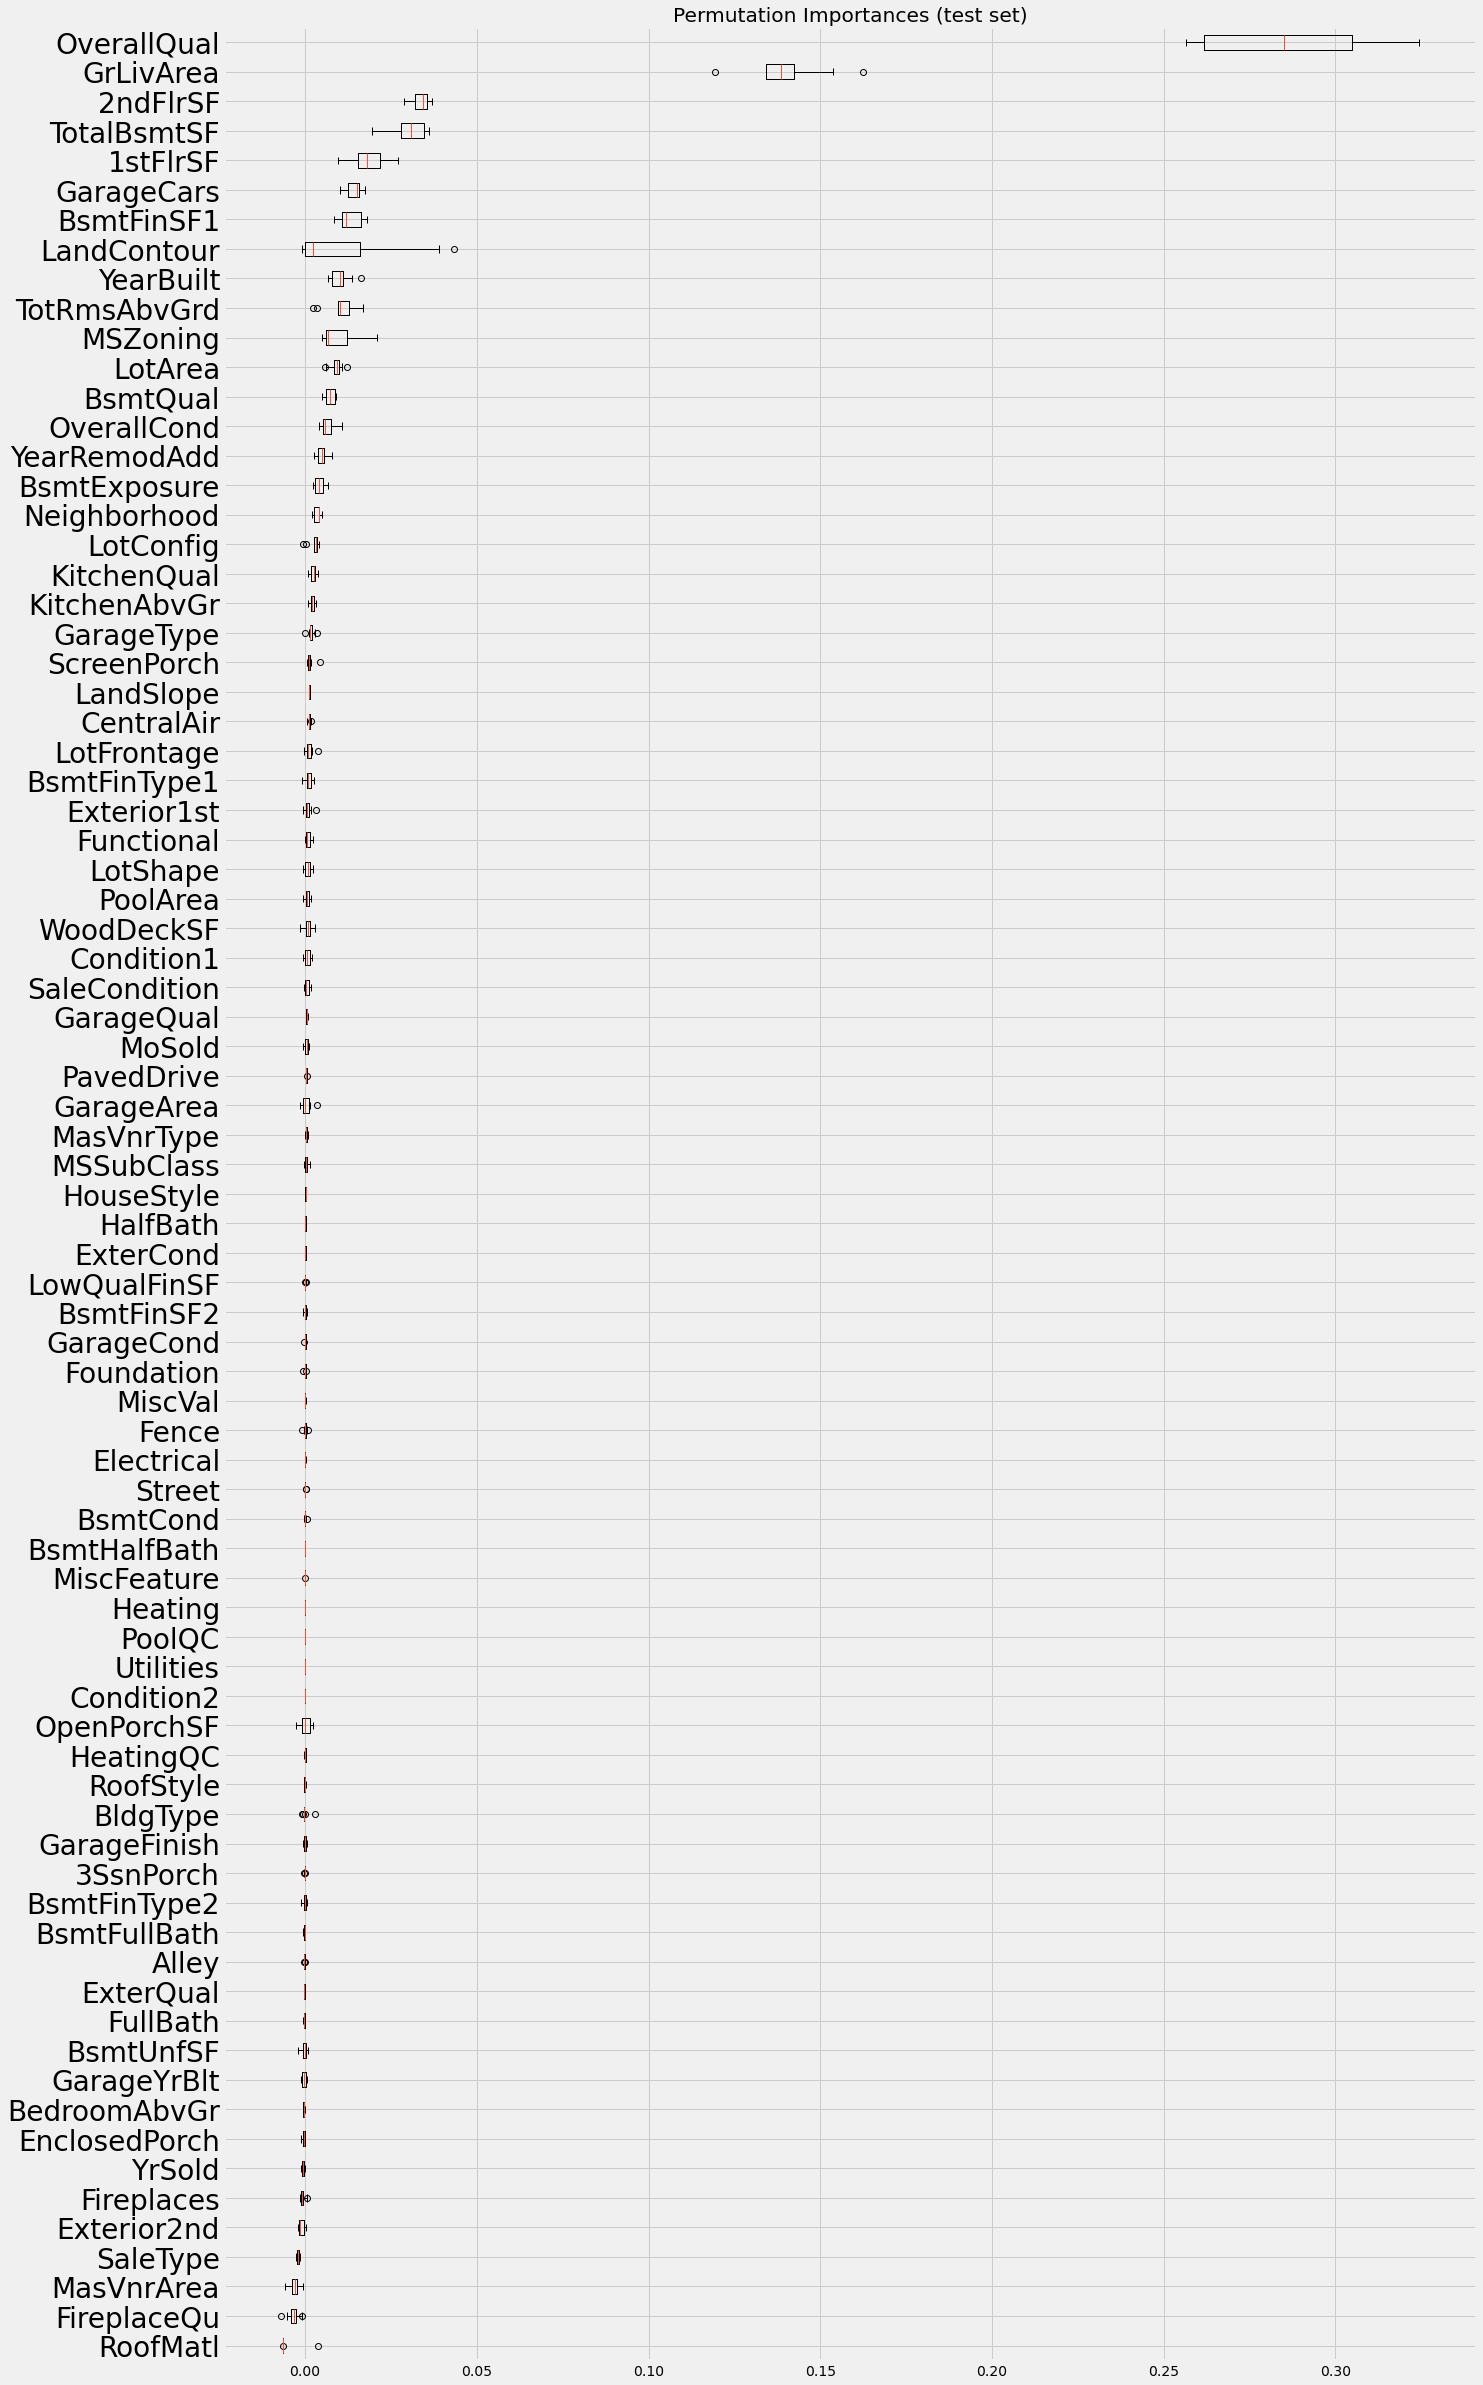

In [14]:
result = permutation_importance(xgb, X_test, y_test, n_repeats=10,random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,40))
plt.boxplot(result.importances[sorted_idx].T,vert=False, labels=X_test.columns[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.yticks(fontsize=28)
plt.show()

In [15]:
# Sorted from worst to best 
X_test.columns[sorted_idx]

Index(['RoofMatl', 'FireplaceQu', 'MasVnrArea', 'SaleType', 'Exterior2nd',
       'Fireplaces', 'YrSold', 'EnclosedPorch', 'BedroomAbvGr', 'GarageYrBlt',
       'BsmtUnfSF', 'FullBath', 'ExterQual', 'Alley', 'BsmtFullBath',
       'BsmtFinType2', '3SsnPorch', 'GarageFinish', 'BldgType', 'RoofStyle',
       'HeatingQC', 'OpenPorchSF', 'Condition2', 'Utilities', 'PoolQC',
       'Heating', 'MiscFeature', 'BsmtHalfBath', 'BsmtCond', 'Street',
       'Electrical', 'Fence', 'MiscVal', 'Foundation', 'GarageCond',
       'BsmtFinSF2', 'LowQualFinSF', 'ExterCond', 'HalfBath', 'HouseStyle',
       'MSSubClass', 'MasVnrType', 'GarageArea', 'PavedDrive', 'MoSold',
       'GarageQual', 'SaleCondition', 'Condition1', 'WoodDeckSF', 'PoolArea',
       'LotShape', 'Functional', 'Exterior1st', 'BsmtFinType1', 'LotFrontage',
       'CentralAir', 'LandSlope', 'ScreenPorch', 'GarageType', 'KitchenAbvGr',
       'KitchenQual', 'LotConfig', 'Neighborhood', 'BsmtExposure',
       'YearRemodAdd', 'OverallCond

### Create csv-file Top12

We started to create a new dataset with only the top 12 columns from X. Then we added a new column 'Saleprice' with contains the values for y.

After a few checks, we save the result to a new csv-file to test.

In [16]:
col_to_keep = sorted_idx[-12:]

In [17]:
new_df = X.iloc[:,col_to_keep]
new_df

,LotArea,MSZoning,TotRmsAbvGrd,YearBuilt,LandContour,BsmtFinSF1,GarageCars,1stFlrSF,TotalBsmtSF,2ndFlrSF,GrLivArea,OverallQual
0,8450,RL,8,2003,Lvl,706,2,856,856,854,1710,7
1,9600,RL,6,1976,Lvl,978,2,1262,1262,0,1262,6
2,11250,RL,6,2001,Lvl,486,2,920,920,866,1786,7
3,9550,RL,7,1915,Lvl,216,3,961,756,756,1717,7
4,14260,RL,9,2000,Lvl,655,3,1145,1145,1053,2198,8
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,RL,7,1999,Lvl,0,2,953,953,694,1647,6
1456,13175,RL,7,1978,Lvl,790,2,2073,1542,0,2073,6
1457,9042,RL,9,1941,Lvl,275,1,1188,1152,1152,2340,7
1458,9717,RL,5,1950,Lvl,49,1,1078,1078,0,1078,5


In [18]:

new_df['Saleprice'] = y

<ipython-input-18-23978787badd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Saleprice'] = y


In [19]:
new_df

,LotArea,MSZoning,TotRmsAbvGrd,YearBuilt,LandContour,BsmtFinSF1,GarageCars,1stFlrSF,TotalBsmtSF,2ndFlrSF,GrLivArea,OverallQual,Saleprice
0,8450,RL,8,2003,Lvl,706,2,856,856,854,1710,7,208500
1,9600,RL,6,1976,Lvl,978,2,1262,1262,0,1262,6,181500
2,11250,RL,6,2001,Lvl,486,2,920,920,866,1786,7,223500
3,9550,RL,7,1915,Lvl,216,3,961,756,756,1717,7,140000
4,14260,RL,9,2000,Lvl,655,3,1145,1145,1053,2198,8,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,RL,7,1999,Lvl,0,2,953,953,694,1647,6,175000
1456,13175,RL,7,1978,Lvl,790,2,2073,1542,0,2073,6,210000
1457,9042,RL,9,1941,Lvl,275,1,1188,1152,1152,2340,7,266500
1458,9717,RL,5,1950,Lvl,49,1,1078,1078,0,1078,5,142125


We create a new csv-file based on this option.

In [20]:
new_df.to_csv('top12andprice.csv', index=False)

### Create csv-file Top10

We repeat the process for top 10 columns from X.

After a few checks, we save the result to a new csv-file to test.

In [21]:
col_to_keep = sorted_idx[-10:]

In [22]:
new_df = X.iloc[:,col_to_keep]
new_df

,TotRmsAbvGrd,YearBuilt,LandContour,BsmtFinSF1,GarageCars,1stFlrSF,TotalBsmtSF,2ndFlrSF,GrLivArea,OverallQual
0,8,2003,Lvl,706,2,856,856,854,1710,7
1,6,1976,Lvl,978,2,1262,1262,0,1262,6
2,6,2001,Lvl,486,2,920,920,866,1786,7
3,7,1915,Lvl,216,3,961,756,756,1717,7
4,9,2000,Lvl,655,3,1145,1145,1053,2198,8
...,...,...,...,...,...,...,...,...,...,...
1455,7,1999,Lvl,0,2,953,953,694,1647,6
1456,7,1978,Lvl,790,2,2073,1542,0,2073,6
1457,9,1941,Lvl,275,1,1188,1152,1152,2340,7
1458,5,1950,Lvl,49,1,1078,1078,0,1078,5


In [23]:
new_df['Saleprice'] = y

<ipython-input-23-23978787badd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Saleprice'] = y


In [24]:
new_df

,TotRmsAbvGrd,YearBuilt,LandContour,BsmtFinSF1,GarageCars,1stFlrSF,TotalBsmtSF,2ndFlrSF,GrLivArea,OverallQual,Saleprice
0,8,2003,Lvl,706,2,856,856,854,1710,7,208500
1,6,1976,Lvl,978,2,1262,1262,0,1262,6,181500
2,6,2001,Lvl,486,2,920,920,866,1786,7,223500
3,7,1915,Lvl,216,3,961,756,756,1717,7,140000
4,9,2000,Lvl,655,3,1145,1145,1053,2198,8,250000
...,...,...,...,...,...,...,...,...,...,...,...
1455,7,1999,Lvl,0,2,953,953,694,1647,6,175000
1456,7,1978,Lvl,790,2,2073,1542,0,2073,6,210000
1457,9,1941,Lvl,275,1,1188,1152,1152,2340,7,266500
1458,5,1950,Lvl,49,1,1078,1078,0,1078,5,142125


We create a new csv-file based on this option.

In [25]:
new_df.to_csv('top10andprice.csv', index=False)

### Create csv-file Top15

We do the same for the top 15 columns from X. Then we added a new column 'Saleprice' with contains the values for y.

After a few checks, we save the result to a new csv-file to test.

In [26]:
col_to_keep = sorted_idx[-15:]

In [27]:
new_df = X.iloc[:,col_to_keep]
new_df

,YearRemodAdd,OverallCond,BsmtQual,LotArea,MSZoning,TotRmsAbvGrd,YearBuilt,LandContour,BsmtFinSF1,GarageCars,1stFlrSF,TotalBsmtSF,2ndFlrSF,GrLivArea,OverallQual
0,2003,5,Gd,8450,RL,8,2003,Lvl,706,2,856,856,854,1710,7
1,1976,8,Gd,9600,RL,6,1976,Lvl,978,2,1262,1262,0,1262,6
2,2002,5,Gd,11250,RL,6,2001,Lvl,486,2,920,920,866,1786,7
3,1970,5,TA,9550,RL,7,1915,Lvl,216,3,961,756,756,1717,7
4,2000,5,Gd,14260,RL,9,2000,Lvl,655,3,1145,1145,1053,2198,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2000,5,Gd,7917,RL,7,1999,Lvl,0,2,953,953,694,1647,6
1456,1988,6,Gd,13175,RL,7,1978,Lvl,790,2,2073,1542,0,2073,6
1457,2006,9,TA,9042,RL,9,1941,Lvl,275,1,1188,1152,1152,2340,7
1458,1996,6,TA,9717,RL,5,1950,Lvl,49,1,1078,1078,0,1078,5


In [28]:
new_df['Saleprice'] = y

<ipython-input-28-23978787badd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Saleprice'] = y


In [29]:
new_df

,YearRemodAdd,OverallCond,BsmtQual,LotArea,MSZoning,TotRmsAbvGrd,YearBuilt,LandContour,BsmtFinSF1,GarageCars,1stFlrSF,TotalBsmtSF,2ndFlrSF,GrLivArea,OverallQual,Saleprice
0,2003,5,Gd,8450,RL,8,2003,Lvl,706,2,856,856,854,1710,7,208500
1,1976,8,Gd,9600,RL,6,1976,Lvl,978,2,1262,1262,0,1262,6,181500
2,2002,5,Gd,11250,RL,6,2001,Lvl,486,2,920,920,866,1786,7,223500
3,1970,5,TA,9550,RL,7,1915,Lvl,216,3,961,756,756,1717,7,140000
4,2000,5,Gd,14260,RL,9,2000,Lvl,655,3,1145,1145,1053,2198,8,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2000,5,Gd,7917,RL,7,1999,Lvl,0,2,953,953,694,1647,6,175000
1456,1988,6,Gd,13175,RL,7,1978,Lvl,790,2,2073,1542,0,2073,6,210000
1457,2006,9,TA,9042,RL,9,1941,Lvl,275,1,1188,1152,1152,2340,7,266500
1458,1996,6,TA,9717,RL,5,1950,Lvl,49,1,1078,1078,0,1078,5,142125


We create a new csv-file based on this option.

In [30]:
new_df.to_csv('top15andprice.csv', index=False)

Now we can use these three csv-files to see how much difference it makes in the model's predictions.

Based on the result, we also did one for top 7.

### Create csv-file Top7

We do the same for the top 7 columns from X. Then we added a new column 'Saleprice' with contains the values for y.

After a few checks, we save the result to a new csv-file to test.

In [31]:
col_to_keep = sorted_idx[-7:]

In [32]:
new_df = X.iloc[:,col_to_keep]
new_df

,BsmtFinSF1,GarageCars,1stFlrSF,TotalBsmtSF,2ndFlrSF,GrLivArea,OverallQual
0,706,2,856,856,854,1710,7
1,978,2,1262,1262,0,1262,6
2,486,2,920,920,866,1786,7
3,216,3,961,756,756,1717,7
4,655,3,1145,1145,1053,2198,8
...,...,...,...,...,...,...,...
1455,0,2,953,953,694,1647,6
1456,790,2,2073,1542,0,2073,6
1457,275,1,1188,1152,1152,2340,7
1458,49,1,1078,1078,0,1078,5


In [33]:
new_df['Saleprice'] = y

<ipython-input-33-23978787badd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Saleprice'] = y


In [34]:
new_df

,BsmtFinSF1,GarageCars,1stFlrSF,TotalBsmtSF,2ndFlrSF,GrLivArea,OverallQual,Saleprice
0,706,2,856,856,854,1710,7,208500
1,978,2,1262,1262,0,1262,6,181500
2,486,2,920,920,866,1786,7,223500
3,216,3,961,756,756,1717,7,140000
4,655,3,1145,1145,1053,2198,8,250000
...,...,...,...,...,...,...,...,...
1455,0,2,953,953,694,1647,6,175000
1456,790,2,2073,1542,0,2073,6,210000
1457,275,1,1188,1152,1152,2340,7,266500
1458,49,1,1078,1078,0,1078,5,142125


We create a new csv-file based on this option.

In [35]:
new_df.to_csv('top7andprice.csv', index=False)

### Create csv-file Top5

We do the same for the top 5 columns from X. Then we added a new column 'Saleprice' with contains the values for y.

After a few checks, we save the result to a new csv-file to test.

In [36]:
col_to_keep = sorted_idx[-5:]

In [37]:
new_df = X.iloc[:,col_to_keep]
new_df

,1stFlrSF,TotalBsmtSF,2ndFlrSF,GrLivArea,OverallQual
0,856,856,854,1710,7
1,1262,1262,0,1262,6
2,920,920,866,1786,7
3,961,756,756,1717,7
4,1145,1145,1053,2198,8
...,...,...,...,...,...
1455,953,953,694,1647,6
1456,2073,1542,0,2073,6
1457,1188,1152,1152,2340,7
1458,1078,1078,0,1078,5


In [38]:
new_df['Saleprice'] = y

<ipython-input-38-23978787badd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Saleprice'] = y


In [39]:
new_df

,1stFlrSF,TotalBsmtSF,2ndFlrSF,GrLivArea,OverallQual,Saleprice
0,856,856,854,1710,7,208500
1,1262,1262,0,1262,6,181500
2,920,920,866,1786,7,223500
3,961,756,756,1717,7,140000
4,1145,1145,1053,2198,8,250000
...,...,...,...,...,...,...
1455,953,953,694,1647,6,175000
1456,2073,1542,0,2073,6,210000
1457,1188,1152,1152,2340,7,266500
1458,1078,1078,0,1078,5,142125


We create a new csv-file based on this option.

In [40]:
new_df.to_csv('top5andprice.csv', index=False)